In [1]:
import pandas as pd
import numpy as np
import time

In [2]:
ratings = pd.read_csv("./ml-latest-small/ratings.csv")
ratings[ratings.userId==1].head(10)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
5,1,70,3.0,964982400
6,1,101,5.0,964980868
7,1,110,4.0,964982176
8,1,151,5.0,964984041
9,1,157,5.0,964984100


In [3]:
movies = pd.read_csv('./ml-latest/movies.csv', encoding='latin-1')
print (movies.shape)
movies.head()

(58098, 3)


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
num_users = ratings.userId.unique().shape[0]
num_items = ratings.movieId.unique().shape[0]
num_users, num_items

(610, 9724)

In [5]:
from sklearn import model_selection as ms
train_set, test_set = ms.train_test_split(ratings, test_size=0.25)
len(train_set), len(test_set)

(75627, 25209)

In [6]:
user_movie_matrix = train_set.pivot(index='userId', columns='movieId', values='rating')
print("UM Matrix value size", user_movie_matrix.values.size)
print("ratings value size", ratings.values.size)
print("Sparisity: {:4.2f}%".format(ratings.rating.values.size/user_movie_matrix.values.size*100))
user_movie_matrix.head(10)

UM Matrix value size 5341160
ratings value size 403344
Sparisity: 1.89%


movieId,1,2,3,4,5,6,7,8,9,10,...,190219,193565,193567,193571,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,4.0,5.0,3.0,5.0,4.0,4.0,3.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# similarity
import math
from operator import itemgetter
from scipy.spatial import distance

def distance_cosine(a,b):
    return 1-distance.cosine(a,b)

def disance_corr(a,b):
    return 1-distance.correlation(a,b)

def distance_euclidean(a,b):
    return 1/(distance.euclidean(a,b)+1)

In [8]:
def nearest_neighbor_user(user, topN, simFunc) :  
    u1 = user_movie_matrix.loc[user].dropna()
    ratedIndex = u1.index
    nn = {}
    
    # Brute-Force Compute
    for uid, row in user_movie_matrix.iterrows():
        interSectionU1 = []
        interSectionU2 = []
        if uid==user:
            continue
            
        for i in ratedIndex:
            if False==math.isnan(row[i]):
                interSectionU1.append(u1[i])
                interSectionU2.append(row[i])
        interSectionLen = len(interSectionU1)
        
        # at least 3 intersection items
        if interSectionLen < 3 :
            continue
            
        # similarity functon
        sim = simFunc(interSectionU1, interSectionU2)
        
        if  math.isnan(sim) == False:
            nn[uid] = sim
            
    # top N returned         
    return sorted(nn.items(),key=itemgetter(1),reverse=True)[:(topN+1)]

In [9]:
def nearest_neighbor_item(movie, topN, simFunc):
    m1 = user_movie_matrix[movie].dropna()
    user_index = m1.index
    nn = {}
    
    for movieId, col in user_movie_matrix.iteritems():
        interSectionU1 = []
        interSectionU2 = []
        if movie == movieId:
            continue
        
        for i in user_index:
            if False==math.isnan(col[i]):
                interSectionU1.append(m1[i])
                interSectionU2.append(col[i])
        interSectionLen = len(interSectionU1)
        
        # at least 3 intersection items
        if interSectionLen < 3:
            continue
            
        # similarity functon
        sim = simFunc(interSectionU1, interSectionU2)
        
        if  math.isnan(sim) == False:
            nn[movieId] = sim
            
    # top N returned         
    return sorted(nn.items(),key=itemgetter(1),reverse=True)[:(topN+1)]

In [10]:
print(pd.DataFrame(nearest_neighbor_user(278, 100, distance_euclidean), columns=['userId', 'sim']).head())
print(pd.DataFrame(nearest_neighbor_item(1, 100, distance_euclidean), columns=['movieId', 'sim']).head())

   userId       sim
0      32  0.666667
1     489  0.666667
2     182  0.585786
3     216  0.585786
4     221  0.585786
   movieId  sim
0     1273  1.0
1     2524  1.0
2     2940  1.0
3     3341  1.0
4     7766  1.0


In [11]:
def predictRating(id_num, nn=50, simFunc=distance_euclidean, kind = 'user') :
   
    if (kind == "user"):
        ## neighboorhood 
        neighbor = nearest_neighbor_user(id_num, nn, simFunc)

        neighbor_id = [id for id, sim in neighbor]
        # List of similar similarities

        ## Remove if two or more are NaN
        neighbor_movie = user_movie_matrix.loc[neighbor_id].dropna(1, how = 'all', thresh = 2)
        # User id x DataFrame of movie id. However, if the NaN of the column is 2 or more, it is deleted.

        neighbor_dic = dict(neighbor)
        ret = [] 
        #['movieId', 'predictedRate']

        # iterate through each column key: userid, column: movieid, value: rating
        for movieId, row in neighbor_movie.iteritems():
            jsum, wsum = 0, 0
            for v in row.dropna().iteritems():
                sim = neighbor_dic.get(v[0],0)
                jsum += sim
                wsum += (v[1]*sim)
            ret.append([movieId, wsum/jsum])

        return ret
    
    elif (kind == 'item'):
        neighbor = nearest_neighbor_item(id_num, nn, simFunc)
        
        neighbor_id = [id for id, sim in neighbor]
        
        neighbor_ratedUser = user_movie_matrix[neighbor_id].dropna(0, how = 'all', thresh = 2)
        
        neighbor_dic = dict(neighbor)
        ret = []
        
        for userId, row in neighbor_ratedUser.iterrows():
            jsum, wsum = 0, 0
            for v in row.dropna().iteritems():
                sim = neighbor_dic.get(v[0], 0)
                jsum += sim
                wsum += (v[1]*sim)
            ret.append([userId, wsum/jsum])
        
        return ret
        

In [12]:
# predictRating(1, 100, kind = 'user')
predictRating(1, 50, kind = 'item')

[[18, 3.4999999999999996],
 [19, 4.0],
 [28, 3.2500000000000004],
 [50, 3.0000000000000004],
 [66, 4.0],
 [74, 4.7661443627634625],
 [84, 3.467711274473075],
 [95, 5.0],
 [105, 4.521072220260462],
 [111, 3.8473814801736412],
 [140, 3.2338556372365375],
 [156, 4.0],
 [177, 4.7583415183791535],
 [182, 4.1014695224061555],
 [186, 4.0],
 [199, 3.616927818618269],
 [202, 4.0],
 [216, 3.0000000000000004],
 [217, 4.0],
 [232, 3.490305787354268],
 [249, 3.8025501614568227],
 [260, 2.7499999999999996],
 [265, 4.0],
 [274, 3.5587218464844197],
 [275, 5.0],
 [290, 4.0],
 [298, 1.4774442146941442],
 [305, 3.833333333333333],
 [307, 3.864474398325835],
 [313, 2.5],
 [318, 4.014248309179893],
 [325, 3.9578555594790767],
 [339, 4.130032993031085],
 [356, 5.0],
 [368, 3.0000000000000004],
 [380, 5.0],
 [381, 3.733855637236537],
 [387, 3.5416666666666665],
 [401, 3.5],
 [414, 3.801426063471611],
 [422, 4.0],
 [469, 4.0],
 [474, 3.8188382098821387],
 [483, 3.8821488698022417],
 [489, 2.9354225489461494]

In [13]:
## view rated movies and movies with high ratings
def ratingMovies(user_id):
    ds = pd.merge(train_set[train_set.userId==user_id], movies, on=['movieId'])
    return ds.sort_values(by=['rating'], ascending=False)[['rating','title','genres','movieId']].head(100)
ratingMovies(1).head()

,rating,title,genres,movieId
0,5.0,Enemy of the State (1998),Action|Thriller,2353
83,5.0,"Clockwork Orange, A (1971)",Crime|Drama|Sci-Fi|Thriller,1206
81,5.0,"Great Mouse Detective, The (1986)",Action|Animation|Children|Crime,2048
80,5.0,Fargo (1996),Comedy|Crime|Drama|Thriller,608
79,5.0,American History X (1998),Crime|Drama,2329


In [14]:
def join_movie_info(predicted_result, movie = 1, kind = 'user'):
    if (kind == 'user'):
        predicted_ratings = pd.DataFrame(predicted_result, columns=['movieId', 'predicted_rating'])
        result_ds = pd.merge(movies[movies.movieId > 0], predicted_ratings, on=['movieId'])
        return result_ds.sort_values(by=['predicted_rating'], ascending=False)
    
    elif (kind == 'item'):
        predicted_ratings = pd.DataFrame(predicted_result, columns=['userId', 'predicted_rating'])
        return predicted_ratings.sort_values(by=['predicted_rating'], ascending=False)
    
result_user = predictRating(50, kind = 'user') # prediction of user #50
result_item = predictRating(1, kind = 'item') # prediction of movie #1
join_movie_info(result_user, kind = 'user').head(10)

,movieId,title,genres,predicted_rating
253,1221,"Godfather: Part II, The (1974)",Crime|Drama,5.0
276,1387,Jaws (1975),Action|Horror,5.0
266,1276,Cool Hand Luke (1967),Drama,5.0
240,1136,Monty Python and the Holy Grail (1975),Adventure|Comedy|Fantasy,5.0
30,58,"Postman, The (Postino, Il) (1994)",Comedy|Drama|Romance,5.0
378,4973,"Amelie (Fabuleux destin d'AmÃ©lie Poulain, Le)...",Comedy|Romance,5.0
311,2324,Life Is Beautiful (La Vita Ã¨ bella) (1997),Comedy|Drama|Romance|War,5.0
256,1228,Raging Bull (1980),Drama,5.0
269,1304,Butch Cassidy and the Sundance Kid (1969),Action|Western,5.0
293,1704,Good Will Hunting (1997),Drama|Romance,5.0


In [15]:
join_movie_info(result_item, kind = 'item').head(10)

,userId,predicted_rating
24,275,5.000000
7,95,5.000000
33,356,5.000000
35,380,5.000000
56,610,4.859577
5,74,4.766144
12,177,4.758342
8,105,4.521072
55,608,4.173691
32,339,4.130033


In [16]:
# 5th user's star rating
userId=1
pd.merge(ratingMovies(userId), join_movie_info(predictRating(userId)), 
         on=['movieId'], how='right').sort_values(by=['predicted_rating'], ascending =False)

,rating,title_x,genres_x,movieId,title_y,genres_y,predicted_rating
29,NaN,NaN,NaN,1387,Jaws (1975),Action|Horror,5.000000
4,5.0,"Princess Bride, The (1987)",Action|Adventure|Comedy|Fantasy|Romance,1197,"Princess Bride, The (1987)",Action|Adventure|Comedy|Fantasy|Romance,5.000000
1,5.0,Fargo (1996),Comedy|Crime|Drama|Thriller,608,Fargo (1996),Comedy|Crime|Drama|Thriller,5.000000
31,NaN,NaN,NaN,6711,Lost in Translation (2003),Comedy|Drama|Romance,5.000000
30,NaN,NaN,NaN,1203,12 Angry Men (1957),Drama,5.000000
8,5.0,"Fugitive, The (1993)",Thriller,457,"Fugitive, The (1993)",Thriller,5.000000
28,NaN,NaN,NaN,4011,Snatch (2000),Comedy|Crime|Thriller,5.000000
27,NaN,NaN,NaN,50872,Ratatouille (2007),Animation|Children|Drama,5.000000
26,NaN,NaN,NaN,261,Little Women (1994),Drama,5.000000
32,NaN,NaN,NaN,924,2001: A Space Odyssey (1968),Adventure|Drama|Sci-Fi,5.000000


In [17]:
eval_ratings = test_set

def eval_prediction(predict, neighbors=50, kind = 'user'):
    if (kind == 'user'):
        ## evaluation
        ds = pd.merge(eval_ratings, test_set[['movieId','rating']].groupby(['movieId']).mean().reset_index(), 
                      on='movieId', how='left')

        ds = ds.rename(columns= {'rating_x':'rating', 'rating_y':'mean_rating'})
        st = time.time()
        ## udpate to predict_rating 
        user_distance_functions = [('user_euclidean',distance_euclidean), ('user_cosine', distance_cosine)]
        for name, func in user_distance_functions:
            ds[name] = 0
            for user_id in predict:
                # key: movie id, value : predicted_rating
                for x in predictRating(user_id, neighbors, func):
                    ds.loc[(ds.userId == user_id) & (ds.movieId == x[0]),name]=x[1]
        #Only the tuple corresponding to the user performing the predict in the entire dataFrame is returned
        return ds[ds.user_euclidean + ds.user_cosine > 0]

                    
    elif (kind == 'item'):
        ## evaluation
        ds = pd.merge(eval_ratings, test_set[['movieId','rating']].groupby(['movieId']).mean().reset_index(), 
                      on='movieId', how='left')

        ds = ds.rename(columns= {'rating_x':'rating', 'rating_y':'mean_rating'})
        st = time.time()
        ## udpate to predict_rating 
        item_distance_functions = [('item_euclidean', distance_euclidean), ('item_cosine', distance_cosine)]
        for name, func in item_distance_functions:
            ds[name] = 0
            for movie_id in predict:
                for x in predictRating(movie_id, neighbors, func, kind = 'item'):
                    ds.loc[(ds.movieId == movie_id) & (ds.userId == x[0]), name] = x[1]
        return ds[ds.item_euclidean + ds.item_cosine > 0]
    
    print('runtime', round(time.time()-st,2), 'sec')
    

In [18]:
## all userId list 
users = user_movie_matrix.index.tolist()
## 10-person star rating
predicted_user = eval_prediction(users[:5], 100, kind = 'user')

predicted_user = predicted_user[(predicted_user['user_cosine'] > 0) & (predicted_user['user_euclidean'] > 0)]

def RMSE(X, left_col, right_col):
    return(np.sqrt(np.mean((X[left_col] - X[right_col])**2)))

def MAE(X, left_col, right_col):
    return(np.mean(np.absolute(X[left_col] - X[right_col])) )

for name in ['mean_rating', 'user_cosine', 'user_euclidean']:
    print ("MAE of {0} is {1} ".format(name, MAE(predicted_user, 'rating', name)))

for name in ['mean_rating', 'user_cosine', 'user_euclidean']:
    print ("RMSE of {0} is {1} ".format(name, RMSE(predicted_user, 'rating', name)))

MAE of mean_rating is 1.0967003293387212 
MAE of user_cosine is 1.1475958529401176 
MAE of user_euclidean is 1.1842778660453543 
RMSE of mean_rating is 1.4437174987588592 
RMSE of user_cosine is 1.5504823255405438 
RMSE of user_euclidean is 1.5756060328233517 


In [19]:
users = user_movie_matrix.index.tolist()
predicted_item = eval_prediction(users[:5], 100, kind = 'item')
predicted_item = predicted_item[(predicted_item['item_cosine'] > 0) & (predicted_item['item_euclidean'] > 0)]

for name in ['mean_rating', 'item_cosine', 'item_euclidean']:
    print ("Item-item MAE of {0} is {1} ".format(name, MAE(predicted_item, 'rating', name)))

for name in ['mean_rating', 'item_cosine', 'item_euclidean']:
    print ("Item-item RMSE of {0} is {1} ".format(name, RMSE(predicted_item, 'rating', name)))

Item-item MAE of mean_rating is 0.684719387755102 
Item-item MAE of item_cosine is 0.7499971877489559 
Item-item MAE of item_euclidean is 0.6065937887718225 
Item-item RMSE of mean_rating is 0.859698239633456 
Item-item RMSE of item_cosine is 0.8940227677236382 
Item-item RMSE of item_euclidean is 0.7528009276484892 


In [20]:
predicted_user

,userId,movieId,rating,timestamp,mean_rating,user_euclidean,user_cosine
279,4,1250,5.0,945174008,4.600000,3.934205,4.309697
364,4,1265,4.0,964622684,3.866667,4.318899,4.275889
565,4,1466,4.0,945173492,3.692308,4.312932,4.212901
952,4,52,3.0,964622786,3.666667,4.000000,4.001372
1250,4,1304,3.0,945078467,3.535714,3.939726,4.268931
1647,4,1084,5.0,945079259,4.083333,3.272826,4.053631
1757,4,1895,4.0,945629179,4.500000,4.000000,4.166188
2816,1,3578,5.0,964980668,3.826923,4.724233,4.333739
2969,1,231,5.0,964981179,3.112903,3.244017,3.376888
2995,4,1291,4.0,964538763,4.045455,4.157141,4.159526


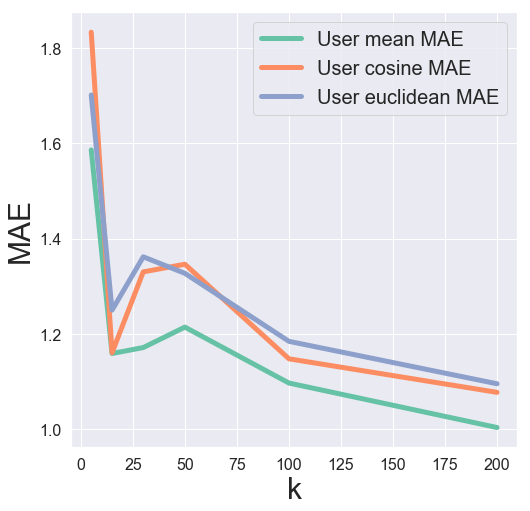

In [21]:
k_array = [5, 15, 30, 50, 100, 200]
user_mean_MAE = []
user_mean_RMSE = []
user_cosine_MAE = []
user_cosine_RMSE = []
user_euc_MAE = []
user_euc_RMSE = []

for k in k_array:
    predicted_user = eval_prediction(users[:5], k, kind = 'user')

    predicted_user = predicted_user[(predicted_user['user_cosine'] > 0) & (predicted_user['user_euclidean'] > 0)]
    
    for name in ['mean_rating', 'user_cosine', 'user_euclidean']:
        if (name == 'mean_rating'):
            user_mean_MAE.append(MAE(predicted_user, 'rating', name))
            user_mean_RMSE.append(RMSE(predicted_user, 'rating', name))
        elif (name == 'user_cosine'):
            user_cosine_MAE.append(MAE(predicted_user, 'rating', name))
            user_cosine_RMSE.append(RMSE(predicted_user, 'rating', name))
        elif (name == 'user_euclidean'):
            user_euc_MAE.append(MAE(predicted_user, 'rating', name))
            user_euc_RMSE.append(RMSE(predicted_user, 'rating', name))

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

pal = sns.color_palette("Set2", 3)
plt.figure(figsize=(8, 8))
plt.plot(k_array, user_mean_MAE, c=pal[0], label='User mean MAE', linewidth=5)
plt.plot(k_array, user_cosine_MAE, c=pal[1], label='User cosine MAE', linewidth=5)
plt.plot(k_array, user_euc_MAE, c=pal[2], label='User euclidean MAE', linewidth=5)
plt.legend(loc='best', fontsize=20)
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.xlabel('k', fontsize=30);
plt.ylabel('MAE', fontsize=30);

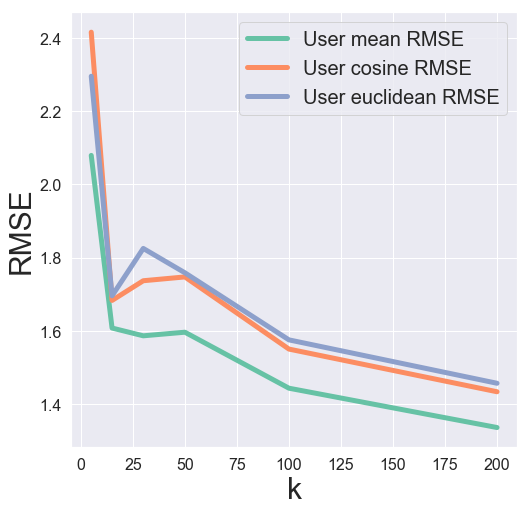

In [22]:
sns.set()

pal = sns.color_palette("Set2", 3)
plt.figure(figsize=(8, 8))
plt.plot(k_array, user_mean_RMSE, c=pal[0], label='User mean RMSE', linewidth=5)
plt.plot(k_array, user_cosine_RMSE, c=pal[1], label='User cosine RMSE', linewidth=5)
plt.plot(k_array, user_euc_RMSE, c=pal[2], label='User euclidean RMSE', linewidth=5)
plt.legend(loc='best', fontsize=20)
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.xlabel('k', fontsize=30);
plt.ylabel('RMSE', fontsize=30);

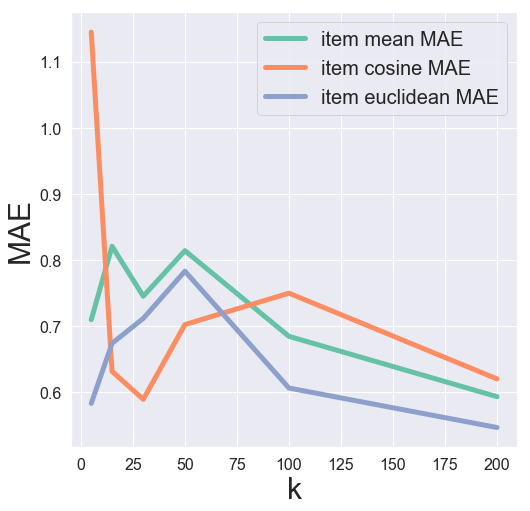

In [23]:
k_array = [5, 15, 30, 50, 100, 200]
item_mean_MAE = []
item_mean_RMSE = []
item_cosine_MAE = []
item_cosine_RMSE = []
item_euc_MAE = []
item_euc_RMSE = []

for k in k_array:
    predicted_item = eval_prediction(users[:5], k, kind = 'item')

    predicted_item = predicted_item[(predicted_item['item_cosine'] > 0) & (predicted_item['item_euclidean'] > 0)]
    
    for name in ['mean_rating', 'item_cosine', 'item_euclidean']:
        if (name == 'mean_rating'):
            item_mean_MAE.append(MAE(predicted_item, 'rating', name))
            item_mean_RMSE.append(RMSE(predicted_item, 'rating', name))
        elif (name == 'item_cosine'):
            item_cosine_MAE.append(MAE(predicted_item, 'rating', name))
            item_cosine_RMSE.append(RMSE(predicted_item, 'rating', name))
        elif (name == 'item_euclidean'):
            item_euc_MAE.append(MAE(predicted_item, 'rating', name))
            item_euc_RMSE.append(RMSE(predicted_item, 'rating', name))

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

pal = sns.color_palette("Set2", 3)
plt.figure(figsize=(8, 8))
plt.plot(k_array, item_mean_MAE, c=pal[0], label='item mean MAE', linewidth=5)
plt.plot(k_array, item_cosine_MAE, c=pal[1], label='item cosine MAE', linewidth=5)
plt.plot(k_array, item_euc_MAE, c=pal[2], label='item euclidean MAE', linewidth=5)
plt.legend(loc='best', fontsize=20)
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.xlabel('k', fontsize=30);
plt.ylabel('MAE', fontsize=30);

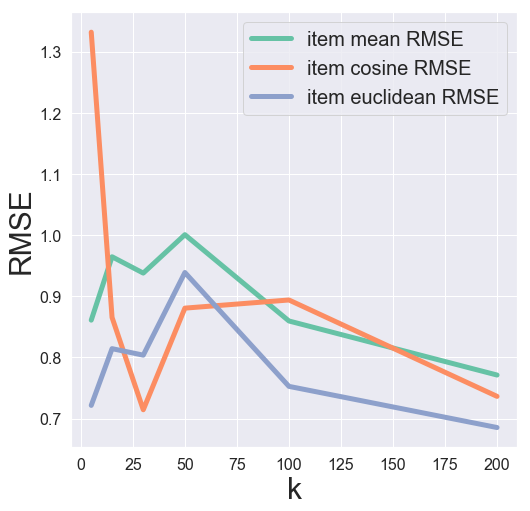

In [24]:
sns.set()

pal = sns.color_palette("Set2", 3)
plt.figure(figsize=(8, 8))
plt.plot(k_array, item_mean_RMSE, c=pal[0], label='item mean RMSE', linewidth=5)
plt.plot(k_array, item_cosine_RMSE, c=pal[1], label='item cosine RMSE', linewidth=5)
plt.plot(k_array, item_euc_RMSE, c=pal[2], label='item euclidean RMSE', linewidth=5)
plt.legend(loc='best', fontsize=20)
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.xlabel('k', fontsize=30);
plt.ylabel('RMSE', fontsize=30);